<a href="https://colab.research.google.com/github/Hadeel-77/U-Net-for-Tumor-Segmentation/blob/main/Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os



In [ ]:
!pip install tensorflow-io



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.2 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


# Unzip The Dataset ( Kaggle Brain MRI Segmentation Dataset)

Source : https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

In [ ]:
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/Tumor.zip'
extract_path = '/content/Tumor'

os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Mounted at /content/drive
✅ Extraction complete!


# Loading & Preprocessing the dataset

###Each folder contains MR images with the following naming convention:


*   TCGA_(institution-code)_(patient-id)_(slice-number).tif

*  Corresponding masks have a  _mask suffix.

*   Each image is 256x256x3
[link text](https://)








In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# --- Config ---

base_path = '/content/Tumor'
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 8

# Splitting files into images and masks
image_list = []
mask_list = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.tif') and not file.endswith('_mask.tif'):
            image_list.append(os.path.join(root, file))
        elif file.endswith('_mask.tif'):
            mask_list.append(os.path.join(root, file))


# To ensure the correct order of having each image with its crossbonding mask

image_list.sort()
mask_list.sort()


# Ensure both images and masks are consistent

print(f"Found {len(image_list)} images and {len(mask_list)} masks")
assert len(image_list) == len(mask_list), "Mismatch between images and masks count!"

# Split into train / val / test

train_imgs, valtest_imgs, train_masks, valtest_masks = train_test_split(
    image_list, mask_list, test_size=0.3, random_state=42
)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    valtest_imgs, valtest_masks, test_size=0.5, random_state=42
)

print(f"Train size: {len(train_imgs)}")
print(f"Validation size: {len(val_imgs)}")
print(f"Test size: {len(test_imgs)}")

# --- Load and preprocess with PIL, wrapped for tf.data ---

def load_tiff_pil(path):

    #Pillow (PIL) needs a normal Python string path, not a TensorFlow tensor.

    path = path.numpy().decode('utf-8')

    # Image is a PIL module opens the converted path and enforce the 3 channel
    img = Image.open(path).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img).astype(np.float32) / 255.0
    return img

def load_mask_pil(path):
    path = path.numpy().decode('utf-8')

    # single channel grayscale for later binary classification

    mask = Image.open(path).convert('L')
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
    mask = np.array(mask)
    mask = (mask > 0).astype(np.uint8)  # binary mask
    mask = np.expand_dims(mask, axis=-1)  # add channel dim ,(IMG_HEIGHT, IMG_WIDTH, 1).
    return mask.astype(np.float32)


# using tf.py_function, TensorFlow treats the function as a black box , the shape info is lost , for that we re-assign the shapes and channels again

def process_path(image_path, mask_path):
    img = tf.py_function(load_tiff_pil, [image_path], tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])

    mask = tf.py_function(load_mask_pil, [mask_path], tf.float32)
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])

    return img, mask


#  Create datasets:  Pair image & mask file paths , Load & preprocess them in parallel, Shuffle for randomness, batch for GPU training, prefetch for speed.

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_masks))
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs, val_masks))
val_dataset = val_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs, test_masks))
test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



Found 7858 images and 7858 masks
Train size: 5500
Validation size: 1179
Test size: 1179


# 1-Encoder Part
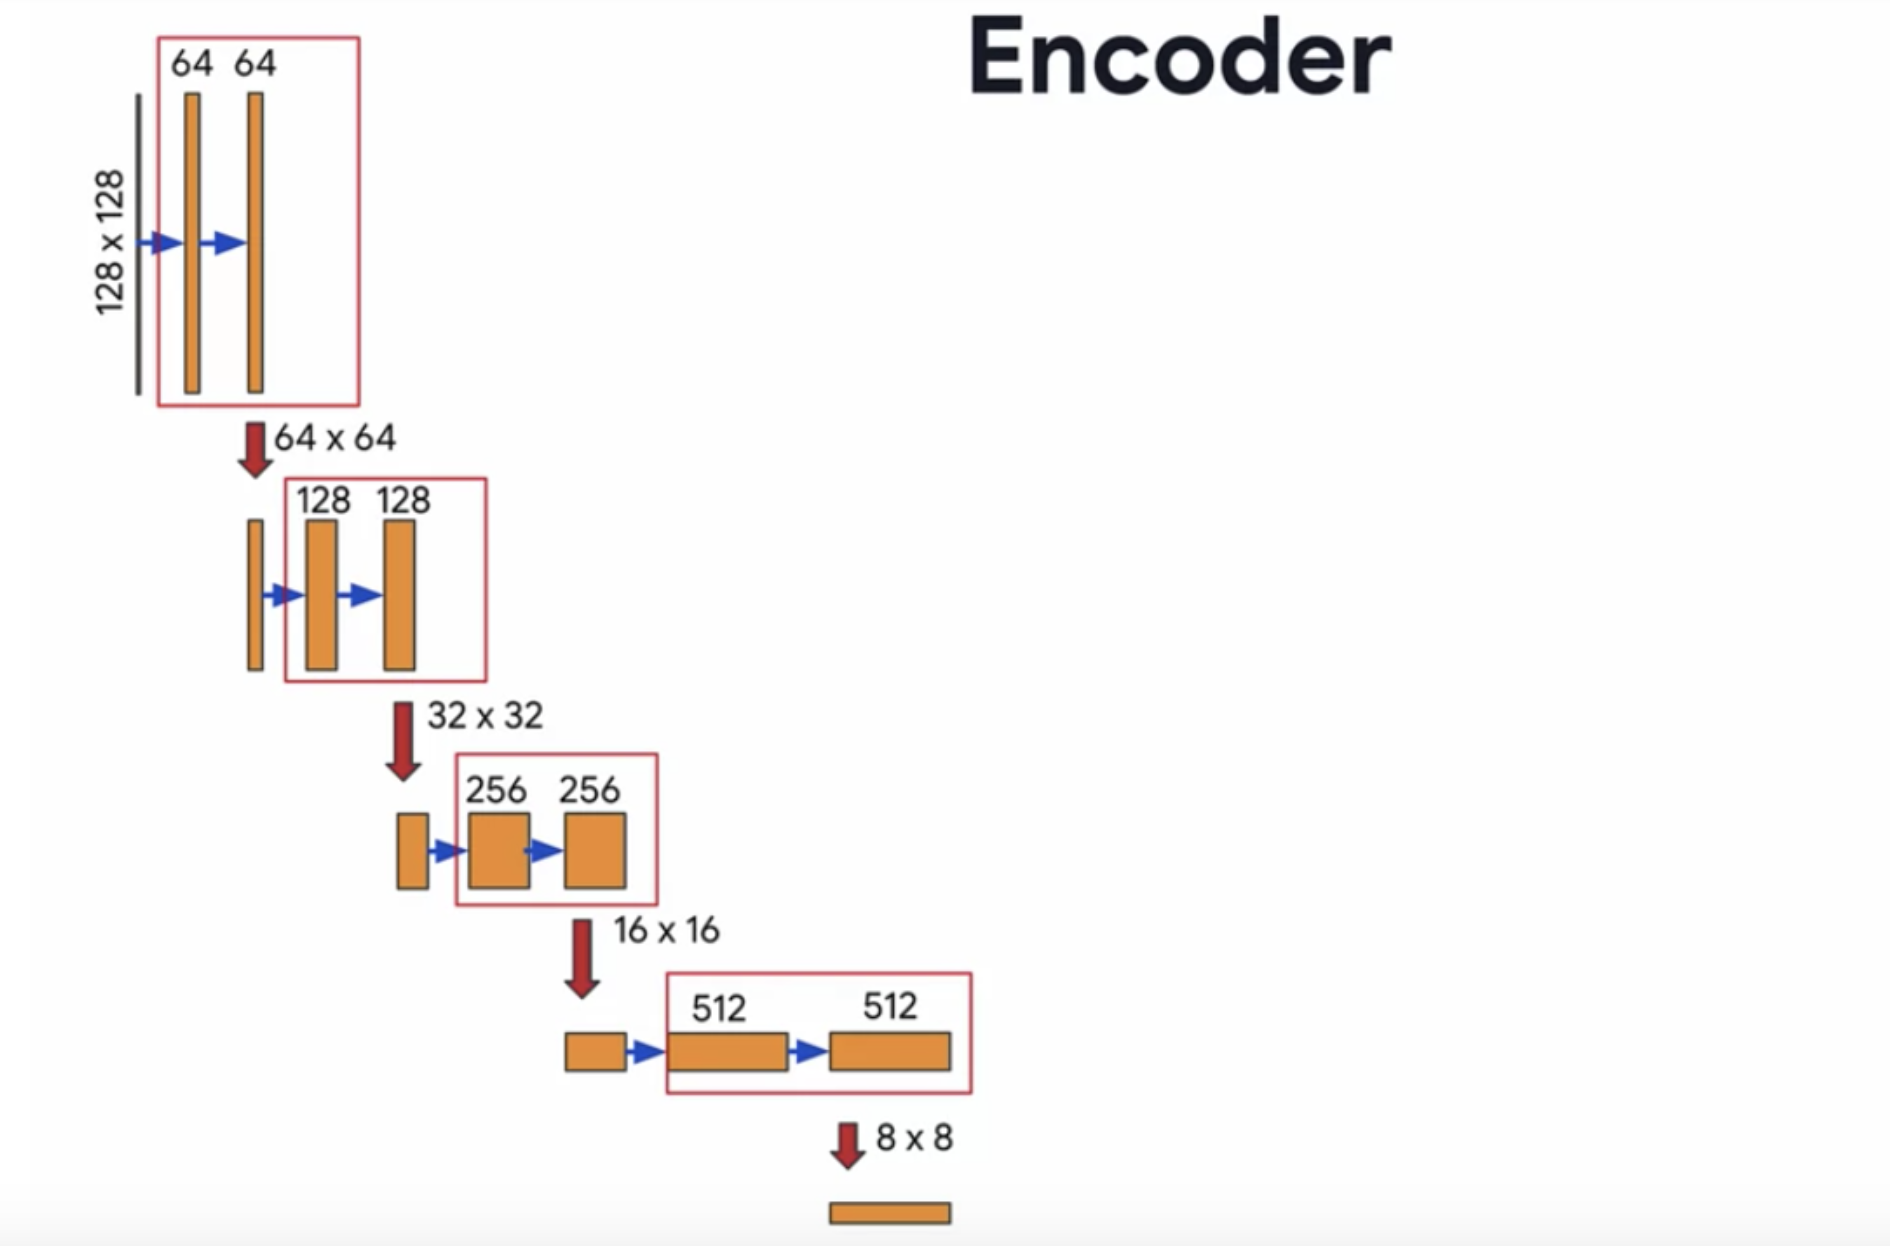

Contains downsampling steps , the size of height and width decreases as
the number of channels increases


* Conv layers (feature extraction) : Two 3x3 same padding convoloution each followed by relu activation
* Max Pooling (downsampling): if set to True, then add a MaxPooling2D layer with 2x2 pool size

* (Optional) Dropout (regularization) : if dropout_prob > 0, then add a dropout layer with parameter dropout_prob



The function will return two tensors:

next_layer: That will go into the next block.
skip_connection: That will go into the corresponding decoding block.

## **Note** :

When max_pooling=True, the skip connection is taken from the output of the convolutional (or dropout) layer before max pooling.

This is because we want to preserve the spatial information at the original resolution to feed into the decoder. Meanwhile, the downsampled output after max pooling is passed to the next layer in the encoder to continue feature extraction at a lower resolution.

If max_pooling=False, there is no downsampling, so both the skip connection and the next layer’s input are the same ,coming directly from the convolutional or dropout layer.



In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """

    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """


    conv = Conv2D(n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)

    conv = Conv2D(n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)


    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:

        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size

    if max_pooling:

        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

# 2- Decoder Part

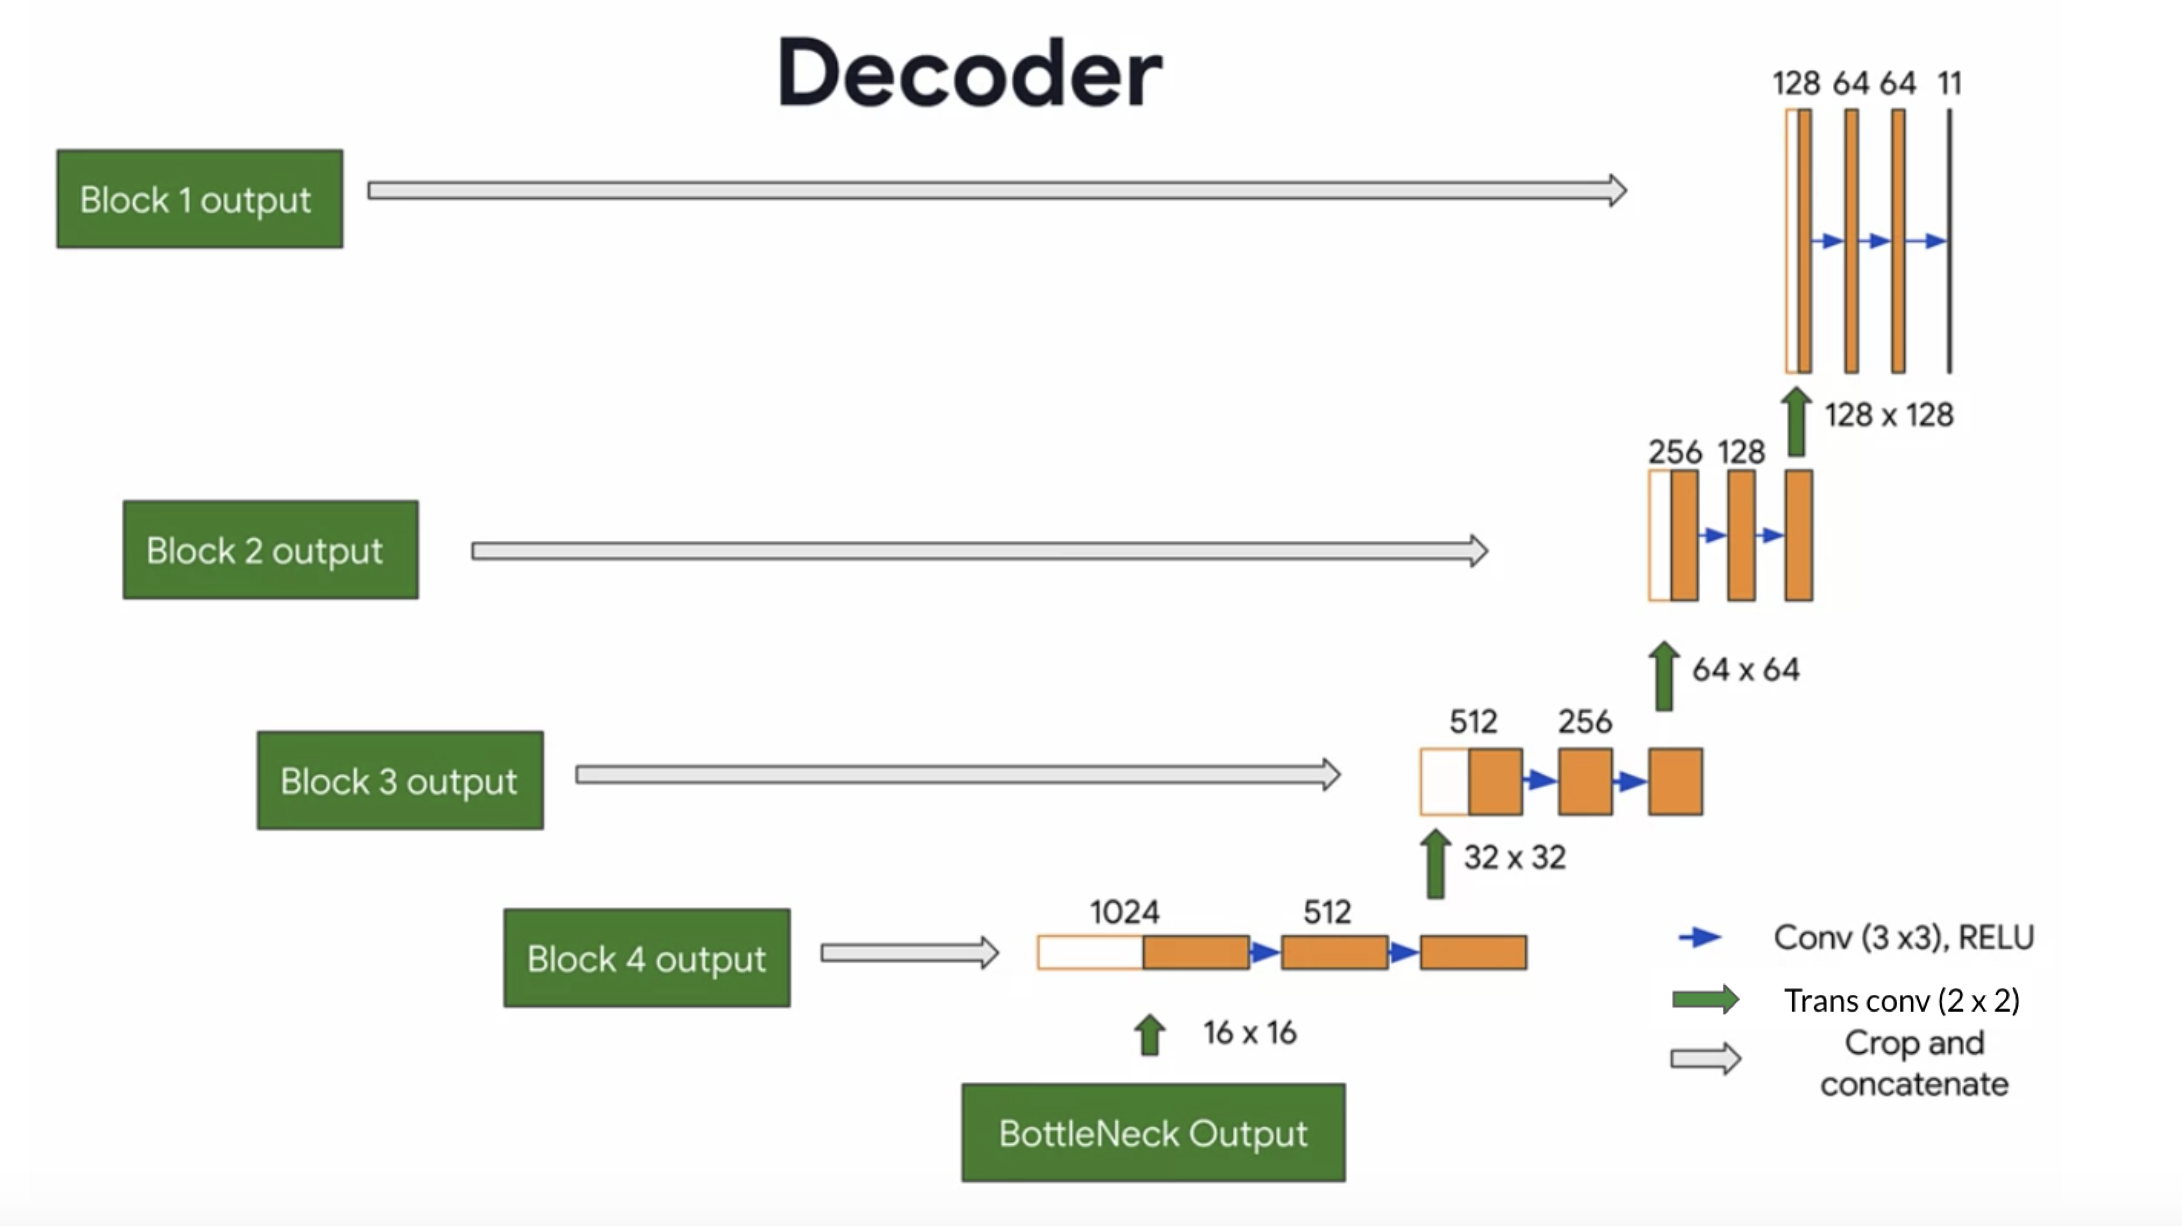




contains the upsampling steps , grows the image back to its size and shrink the channel gradually :





* 3x3 transpose convolution : halves the number of channels & grows the     height and width applied on the output of the last block in the encoder (low-resolution, high-feature representation)

* concat with the image extracted from the skip connection(which carries higher-resolution spatial information)
* Two 3x3 convolution (refine the features)




In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, concatenate

def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Convolutional upsampling block

    Arguments:
    expansive_input -- Tensor, from previous layer (decoder side)
    contractive_input -- Tensor, from corresponding encoder layer (skip connection)
    n_filters -- number of convolutional filters

    Returns:
    tuple of (next_layer, skip_connection) -- both tensors
    """
    # 1) Upsample the input
    up = Conv2DTranspose(n_filters, kernel_size=3, strides=2, padding='same')(expansive_input)

    # 2) Concatenate with the skip connection from contracting path
    merge = concatenate([up, contractive_input], axis=3)

    # 3) Two conv layers after concatenation
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    # 4) Return a tuple so that next call can use [0] for next layer and [1] for skip
    return conv, conv


# Final Structure

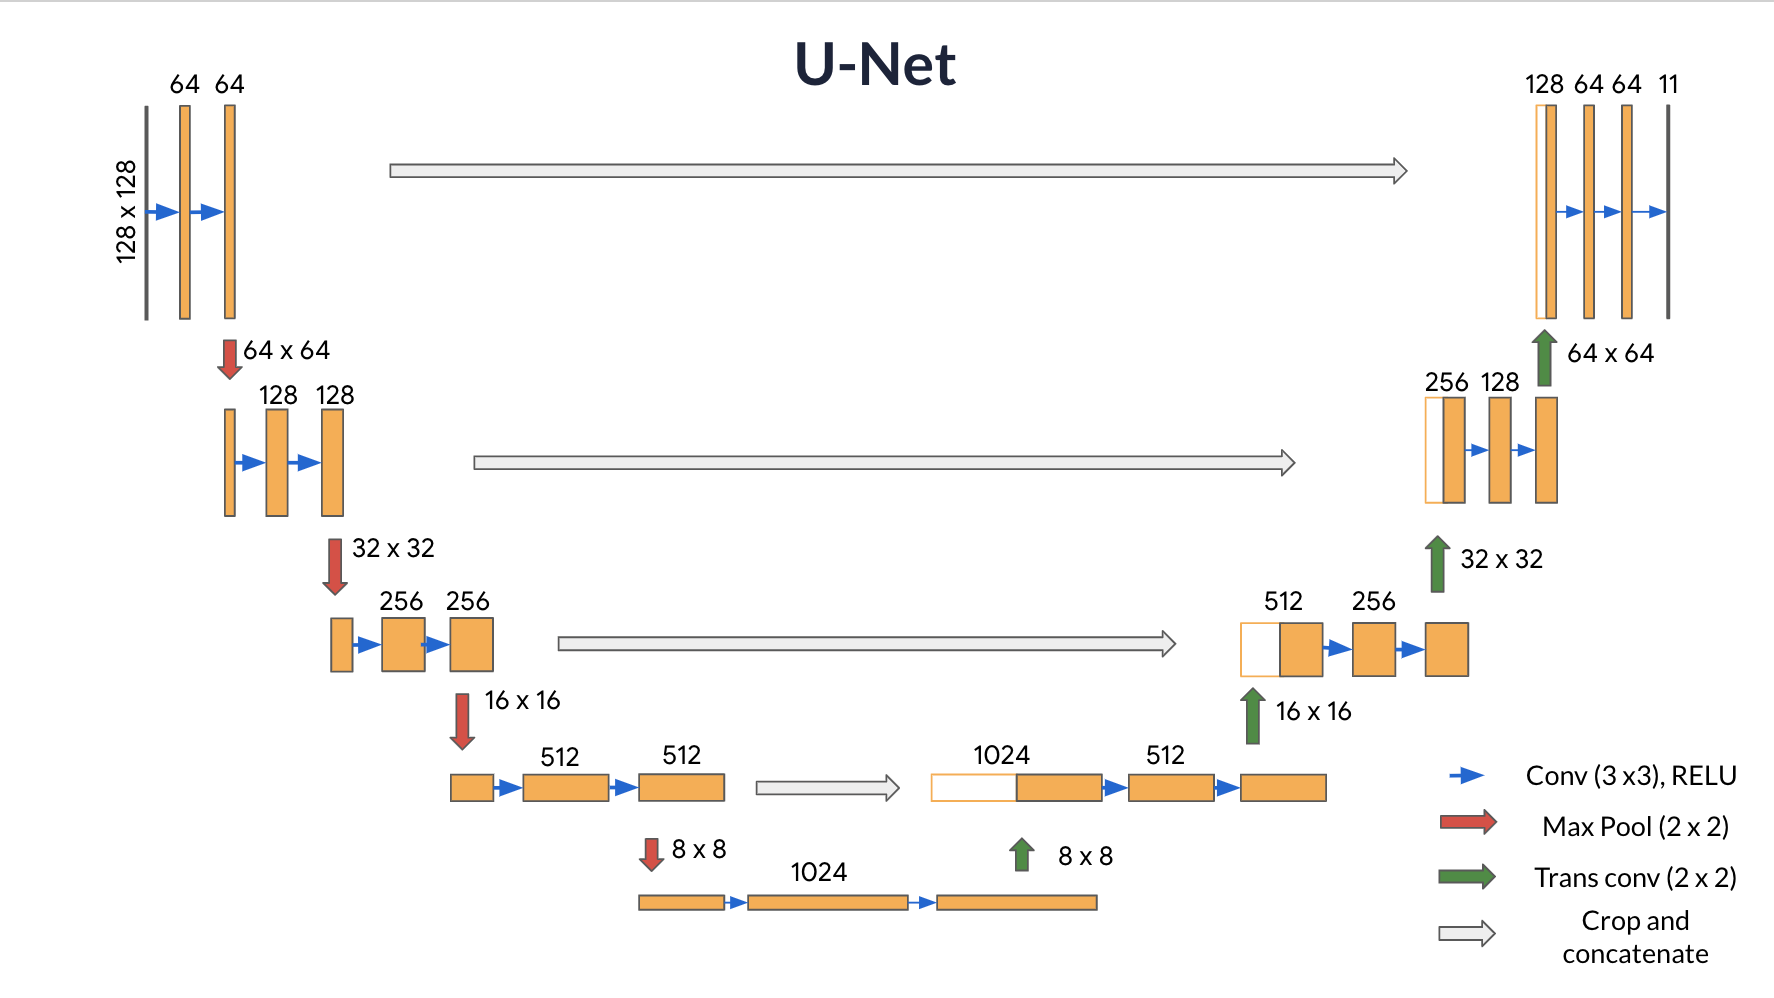

In [ ]:
def unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    inputs = Input(input_size)

    # Contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6[0], cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7[0], cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8[0], cblock1[1], n_filters)

# further refines the features after all the upsampling and concatenations.
    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9[0])

# final output layer
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model


In [ ]:
model = unet_model(input_size=(128,128,3), n_filters=32, n_classes=2)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model = unet_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# -------------------
# Prediction and Visualization
# -------------------


Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 2905s 4s/step - accuracy: 0.9818 - loss: 0.2239 - val_accuracy: 0.9897 - val_loss: 0.0334
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 2977s 4s/step - accuracy: 0.9899 - loss: 0.0352 - val_accuracy: 0.9905 - val_loss: 0.0311
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 2979s 4s/step - accuracy: 0.9902 - loss: 0.0331 - val_accuracy: 0.9913 - val_loss: 0.0284
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 2958s 4s/step - accuracy: 0.9907 - loss: 0.0317 - val_accuracy: 0.9912 - val_loss: 0.0289
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 3014s 4s/step - accuracy: 0.9910 - loss: 0.0308 - val_accuracy: 0.9921 - val_loss: 0.0256


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


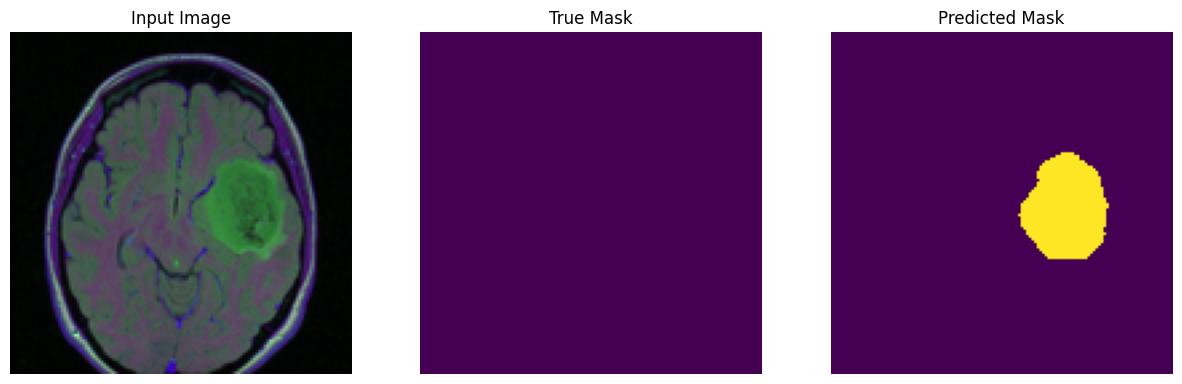

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


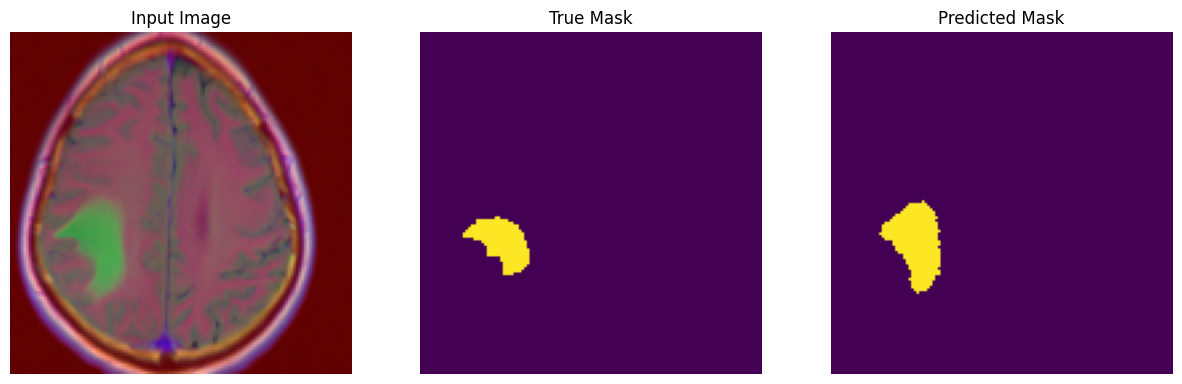

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


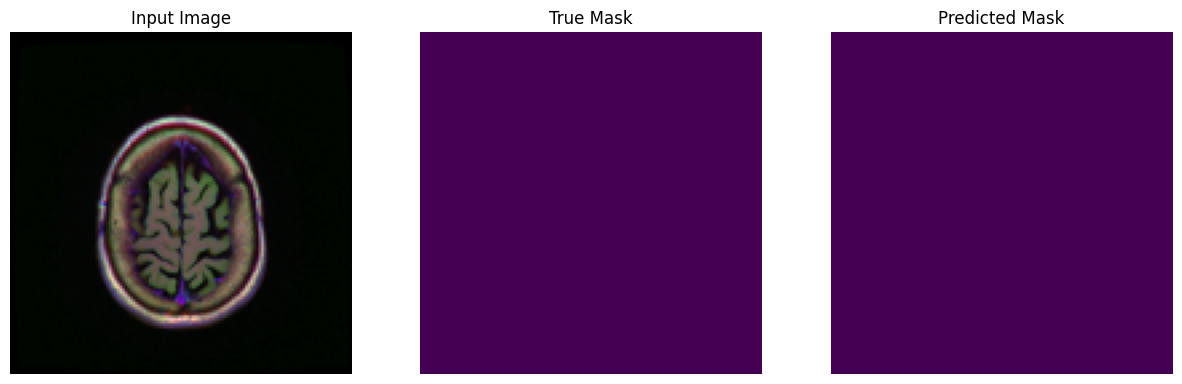

In [ ]:
import matplotlib.pyplot as plt
def display_sample(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for img, mask in test_dataset.take(3):
    pred_mask = model.predict(img)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    display_sample([img[5], mask[5], pred_mask[5]])